In [6]:
import requests
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns

CORE NETO POZICIJE DRŽAV

In [6]:
# Define the URL and query parameters
url = "https://publicationtool.jao.eu/core/api/data/d2CF"
# params = {"FromUtc": "2025-02-08T23:00:00.000Z","ToUtc": "2025-02-09T23:00:00.000Z"}
params = {"FromUtc": "2025-01-25T23:00:00.000Z","ToUtc": "2025-01-26T23:00:00.000Z"}

try:
    response = requests.get(url, params=params, verify=False)
    response.raise_for_status()  
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

data_list = data['data']
df = pd.DataFrame(data_list)
# Convert to Ljubljana time zone (Europe/Ljubljana)
df['dateTimeUtc'] = pd.to_datetime(df['dateTimeUtc'], utc=True)
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_convert(pytz.timezone('Europe/Ljubljana'))
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_localize(None)
df = df.drop(df.columns[0], axis=1) # Nepotreben 'id' stolpec

# Ločimo generacijo/odjem in CORE NET pozicije 
columns_to_extract_load = [df.columns[0]] + [col for col in df.columns if col.startswith('verticalLoad')]
columns_to_extract_gen = [df.columns[0]] + [col for col in df.columns if col.startswith('generation')]
# Določimo df in preimenujemo stolpce
df_load = df[columns_to_extract_load]; df_gen = df[columns_to_extract_gen]
df_load.columns = [col.replace('verticalLoad_', '') for col in df_load.columns]; df_gen.columns = [col.replace('generation_', '') for col in df_gen.columns]
df_net_pos_core = df_gen.iloc[:, 1:] - df_load.iloc[:, 1:]
df_net_pos_core['dateTimeUtc'] = df_gen.iloc[:, 0] 

df_net_pos_core['dateTimeUtc'] = pd.to_datetime(df_net_pos_core['dateTimeUtc'])
df_net_pos_core['Hour_Minute'] = df_net_pos_core['dateTimeUtc'].dt.strftime('%H')
df_net_pos_core.drop(columns=["dateTimeUtc"], inplace=True)
df_net_pos_core['Hour_Minute'] = df_net_pos_core['Hour_Minute'].astype(int).astype(str) + ":30"
df_net_pos_core.set_index('Hour_Minute', inplace=True)
df_net_pos_core = df_net_pos_core.T

C:\Users\Jaka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'publicationtool.jao.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


NON CORE neto pozicije držav 

In [7]:
# Define the URL and query parameters
url = "https://publicationtool.jao.eu/core/api/data/referenceNetPosition"
# params = {"FromUtc": "2025-01-22T23:00:00.000Z","ToUtc": "2025-01-23T23:00:00.000Z"}

try:
    response = requests.get(url, params=params, verify=False)
    response.raise_for_status()  
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

data_list = data['data']
df = pd.DataFrame(data_list)
# Convert to Ljubljana time zone (Europe/Ljubljana)
df['dateTimeUtc'] = pd.to_datetime(df['dateTimeUtc'], utc=True)
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_convert(pytz.timezone('Europe/Ljubljana'))
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_localize(None)
df = df.drop(df.columns[0], axis=1) # Nepotreben 'id' stolpec

columns_to_extract = [df.columns[0]] + [col for col in df.columns if col.startswith('globalNetPosition')]
df_net_pos_other = df[columns_to_extract]
df_net_pos_other.columns = [col.replace('globalNetPosition_', '') for col in df_net_pos_other.columns]

date_str = df['dateTimeUtc'].iloc[0].strftime('%d.%m.%Y')
df_net_pos_other['dateTimeUtc'] = pd.to_datetime(df_net_pos_other['dateTimeUtc'])
df_net_pos_other['Hour_Minute'] = df_net_pos_other['dateTimeUtc'].dt.strftime('%H')
df_net_pos_other.drop(columns=["dateTimeUtc"], inplace=True)
df_net_pos_other['Hour_Minute'] = df_net_pos_other['Hour_Minute'].astype(int).astype(str) + ":30"
df_net_pos_other.set_index('Hour_Minute', inplace=True)
df_net_pos_other = df_net_pos_other.T

C:\Users\Jaka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'publicationtool.jao.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
df_net_pos = pd.concat([df_net_pos_core, df_net_pos_other], axis=0, ignore_index=False)
df_net_pos = df_net_pos[~df_net_pos.index.isin(['KS'])]
country_mapping = {
    'AT': 'Austria', 'BE': 'Belgium', 'CZ': 'Czech Republic', 'DE': 'Germany', 'FR': 'France', 
    'HR': 'Croatia', 'HU': 'Hungary', 'NL': 'Netherlands', 'PL': 'Poland', 'RO': 'Romania', 
    'SI': 'Slovenia', 'SK': 'Slovakia', '50Hertz': '50 Hertz', 'Amprion': 'AMPRION', 'Creos': 'Luxembourg',
    'TennetGmbh': 'TennetGmbh', 'Transnet': 'TransnetBW', 'AL': 'Albania', 'BA': 'BiH', 
    'BG': 'Bulgaria', 'CH': 'Switzerland', 'DK1': 'Denmark', 'ES': 'Spain', 
    'GR': 'Greece', 'IT': 'Italy', 'ME': 'Montenegro', 'MK': 'Macedonia', 
    'PT': 'Portugal', 'RS': 'Serbia', 'TR': 'Turkey', 'UA': 'Ukraine', 'KS': 'Kosovo'
}
df_net_pos.index = df_net_pos.index.map(country_mapping)
move_to_bottom = ['Germany', '50Hertz', 'Amprion', 'TennetGmbh', 'TransnetBW', 'Luxembourg']
# Separate the DataFrame into two parts
df_top = df_net_pos[~df_net_pos.index.isin(move_to_bottom)].sort_index()  # Sort others alphabetically
df_top = df_top.sort_index(ascending=True)
df_bottom = df_net_pos[df_net_pos.index.isin(move_to_bottom)]  # Keep specified rows
# Concatenate with the desired order
df_net_pos = pd.concat([df_top, df_bottom])


In [107]:
df_balkan = df_net_pos.loc[['BiH', 'Croatia', 'Serbia', 'Montenegro', 'Macedonia', 'Albania','Turkey', 'Greece', 'Bulgaria'], :] # Izberi države iz Balkana
df_nib = df_net_pos.loc[['Austria', 'Slovenia', 'Italy', 'Switzerland', 'France'], :] # Izberi države iz NIB
df_vzhod = df_net_pos.loc[['Hungary', 'Slovakia', 'Czech Republic', 'Poland', 'Ukraine', 'Romania'], :] # Izberi države iz Vzhodne Evrope
df_sever = df_net_pos.loc[['50 Hertz', 'Netherlands', 'Belgium', 'AMPRION', 'Denmark','TennetGmbh', 'TransnetBW'], :] # Izberi države iz Severne Evrope
df_iberia = df_net_pos.loc[['Portugal', 'Spain'], :] # Izberi države iz Iberijskega polotoka

# Neto po regijah
df_balkan.loc["Neto"] = df_balkan.sum(axis=0).astype(int)
df_nib.loc["Neto"] = df_nib.sum(axis=0).astype(int)
df_vzhod.loc["Neto"] = df_vzhod.sum(axis=0).astype(int)
df_sever.loc["Neto"] = df_sever.sum(axis=0).astype(int)
df_iberia.loc["Neto"] = df_iberia.sum(axis=0).astype(int)

In [108]:
# Calculate the target length
target_length = len("Czech Republic")
# Rename 'Czech Republic' by padding it with spaces at the beginning
df_sever = df_sever.rename(index={"TennetGmbh": "  TennetGmbh".rjust(target_length)})
df_iberia = df_iberia.rename(index={"Portugal": "  Portugal".rjust(target_length+5)})
df_nib = df_nib.rename(index={"Switzerland": "  Switzerland".rjust(target_length+2)})
df_balkan = df_balkan.rename(index={"Montenegro": "  Montenegro".rjust(target_length)})

# Neto po regijah
df_balkan.loc["Neto"] = df_balkan.sum(axis=0).astype(int)
df_nib.loc["Neto"] = df_nib.sum(axis=0).astype(int)
df_vzhod.loc["Neto"] = df_vzhod.sum(axis=0).astype(int)
df_sever.loc["Neto"] = df_sever.sum(axis=0).astype(int)
df_iberia.loc["Neto"] = df_iberia.sum(axis=0).astype(int)

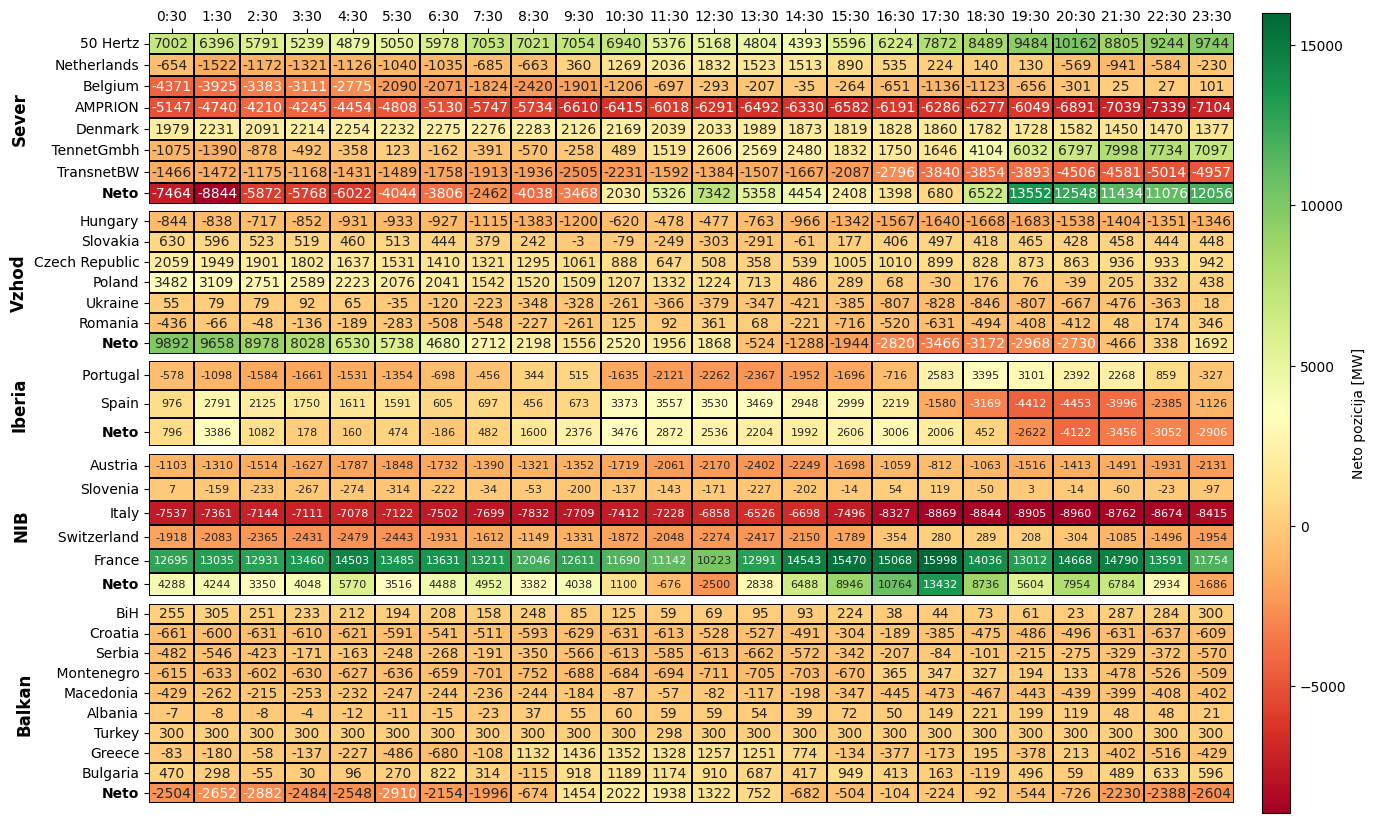

In [113]:
fig_2, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [0.6, 0.5, 0.3, 0.5,0.7]})  # Adjust the last value for lower height
yticksize = 10
# SEVER heatmap
sns.heatmap(df_sever, cmap='RdYlGn', annot=True, fmt='.0f', linecolor='black', linewidths=0.1, 
            cbar=False, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_ylabel('Sever', fontsize=12, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)
axes[0].xaxis.set_ticks_position('top')
axes[0].tick_params(axis='y', labelsize=yticksize) 
y_tick_labels = axes[0].get_yticklabels(); y_tick_labels[-1].set_fontweight('bold'); axes[0].set_yticklabels(y_tick_labels)

# VZHOD heatmap
sns.heatmap(df_vzhod, cmap='RdYlGn', annot=True, fmt='.0f', linecolor='black', linewidths=0.1, 
            cbar=False, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_ylabel('Vzhod', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)
axes[1].set_xticklabels([]); axes[1].xaxis.set_ticks([])  # Remove x-axis ticks completely
axes[1].tick_params(axis='y', labelsize=yticksize) 
y_tick_labels = axes[1].get_yticklabels(); y_tick_labels[-1].set_fontweight('bold'); axes[1].set_yticklabels(y_tick_labels)

# IBERIA heatmap
sns.heatmap(df_iberia, cmap='RdYlGn', annot=True, fmt='.0f', linecolor='black', linewidths=0.1, 
            cbar=False, vmin=vmin, vmax=vmax, annot_kws={"size": 8}, ax=axes[2])
axes[2].set_ylabel('Iberia', fontsize=12, fontweight='bold')  # Move y-label to the right and change color
axes[2].set_xlabel('')
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0)
axes[2].set_xticklabels([]); axes[2].xaxis.set_ticks([])  # Remove x-axis ticks completely
axes[2].tick_params(axis='y', labelsize=yticksize) 
y_tick_labels = axes[2].get_yticklabels(); y_tick_labels[-1].set_fontweight('bold'); axes[2].set_yticklabels(y_tick_labels)

# NIB heatmap
sns.heatmap(df_nib, cmap='RdYlGn', annot=True, fmt='.0f', linecolor='black', linewidths=0.1, 
            cbar=False, vmin=vmin, vmax=vmax, annot_kws={"size": 8}, ax=axes[3])
axes[3].set_ylabel('NIB', fontsize=12, fontweight='bold')
axes[3].set_xlabel('')
axes[3].set_yticklabels(axes[3].get_yticklabels(), rotation=0)
axes[3].set_xticklabels([]); axes[3].xaxis.set_ticks([])  # Remove x-axis ticks completely
axes[3].tick_params(axis='y', labelsize=yticksize) 
y_tick_labels = axes[3].get_yticklabels(); y_tick_labels[-1].set_fontweight('bold'); axes[3].set_yticklabels(y_tick_labels)

# BALKAN heatmap
sns.heatmap(df_balkan, cmap='RdYlGn', annot=True, fmt='.0f', linecolor='black', linewidths=0.1, 
            cbar=False, vmin=vmin, vmax=vmax, ax=axes[4])
axes[4].set_ylabel('Balkan', fontsize=12, fontweight='bold')
axes[4].set_xlabel('')
axes[4].set_yticklabels(axes[4].get_yticklabels(), rotation=0)
axes[4].set_xticklabels([]); axes[4].xaxis.set_ticks([])  # Remove x-axis ticks completely
axes[4].tick_params(axis='y', labelsize=yticksize) 
y_tick_labels = axes[4].get_yticklabels(); y_tick_labels[-1].set_fontweight('bold'); axes[4].set_yticklabels(y_tick_labels)

# Create a single color bar for all heatmaps (after the subplots are done)
cbar_ax = fig_2.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height] (position the color bar)
norm = plt.Normalize(vmin=vmin, vmax=vmax)  # Normalize the color range for all subplots
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array([])  # Set empty array for color bar display

# Add the color bar to the figure
fig_2.colorbar(sm, cax=cbar_ax, label='Neto pozicija [MW]')
plt.subplots_adjust(hspace=0.05, right=0.9)  # Adjust spacing and allow space for the color bar




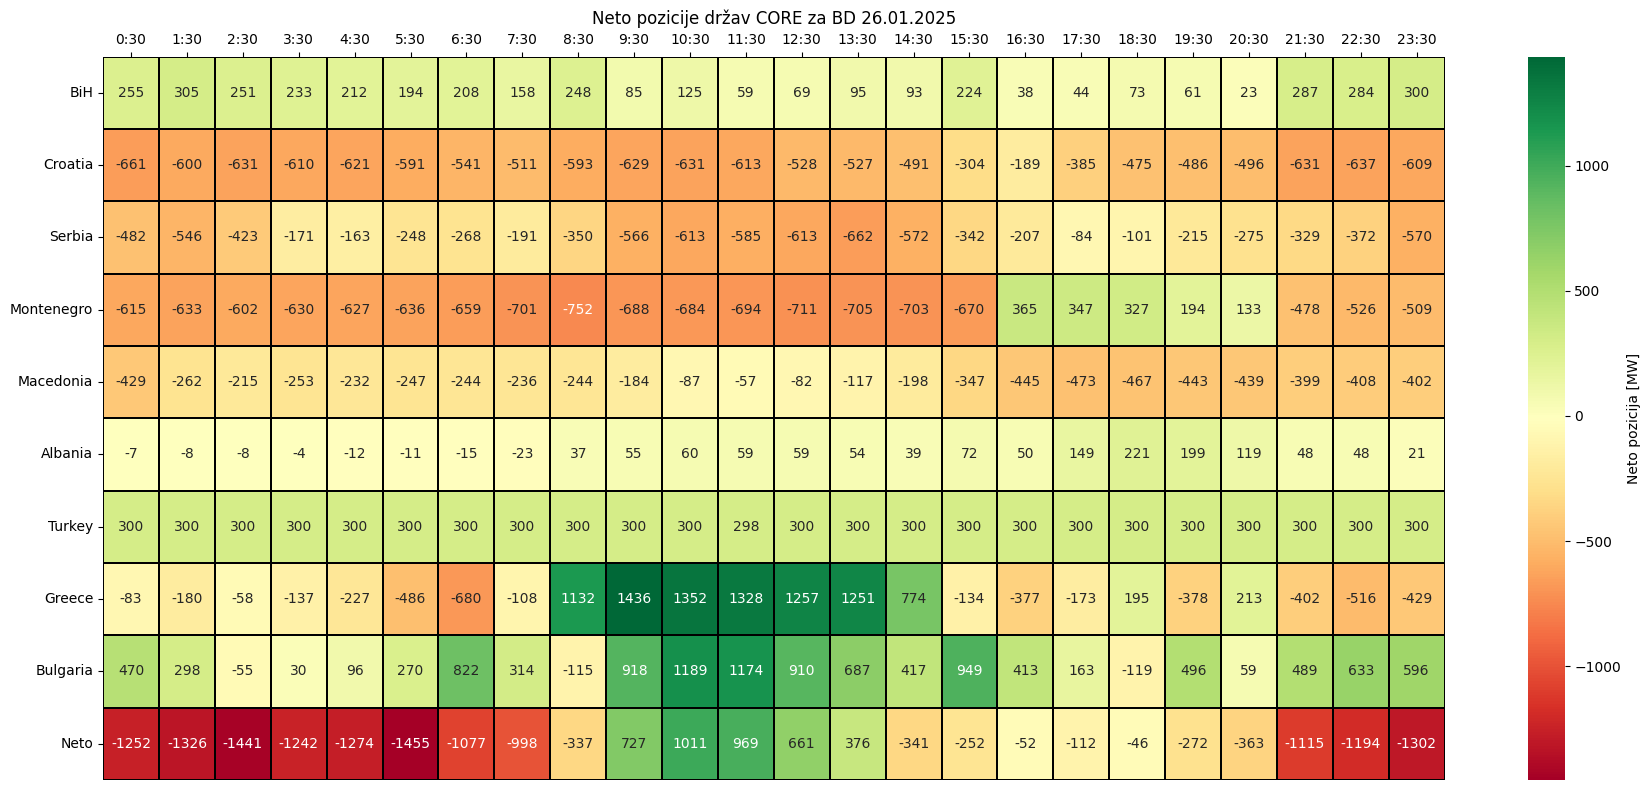

In [16]:
date_str = df['dateTimeUtc'].iloc[0].strftime('%d.%m.%Y')
# Create heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(df_balkan, cmap='RdYlGn', annot=True, fmt='.0f',linecolor='black', linewidths=0.1, cbar_kws={'label': 'Neto pozicija [MW]'})
# Configure plot
plt.title(f'Neto pozicije držav CORE za BD {date_str}')
plt.gca().xaxis.set_ticks_position('top')
plt.ylabel('')
plt.xlabel('')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [38]:
a = df_net_pos

In [ ]:
# b = df_net_pos

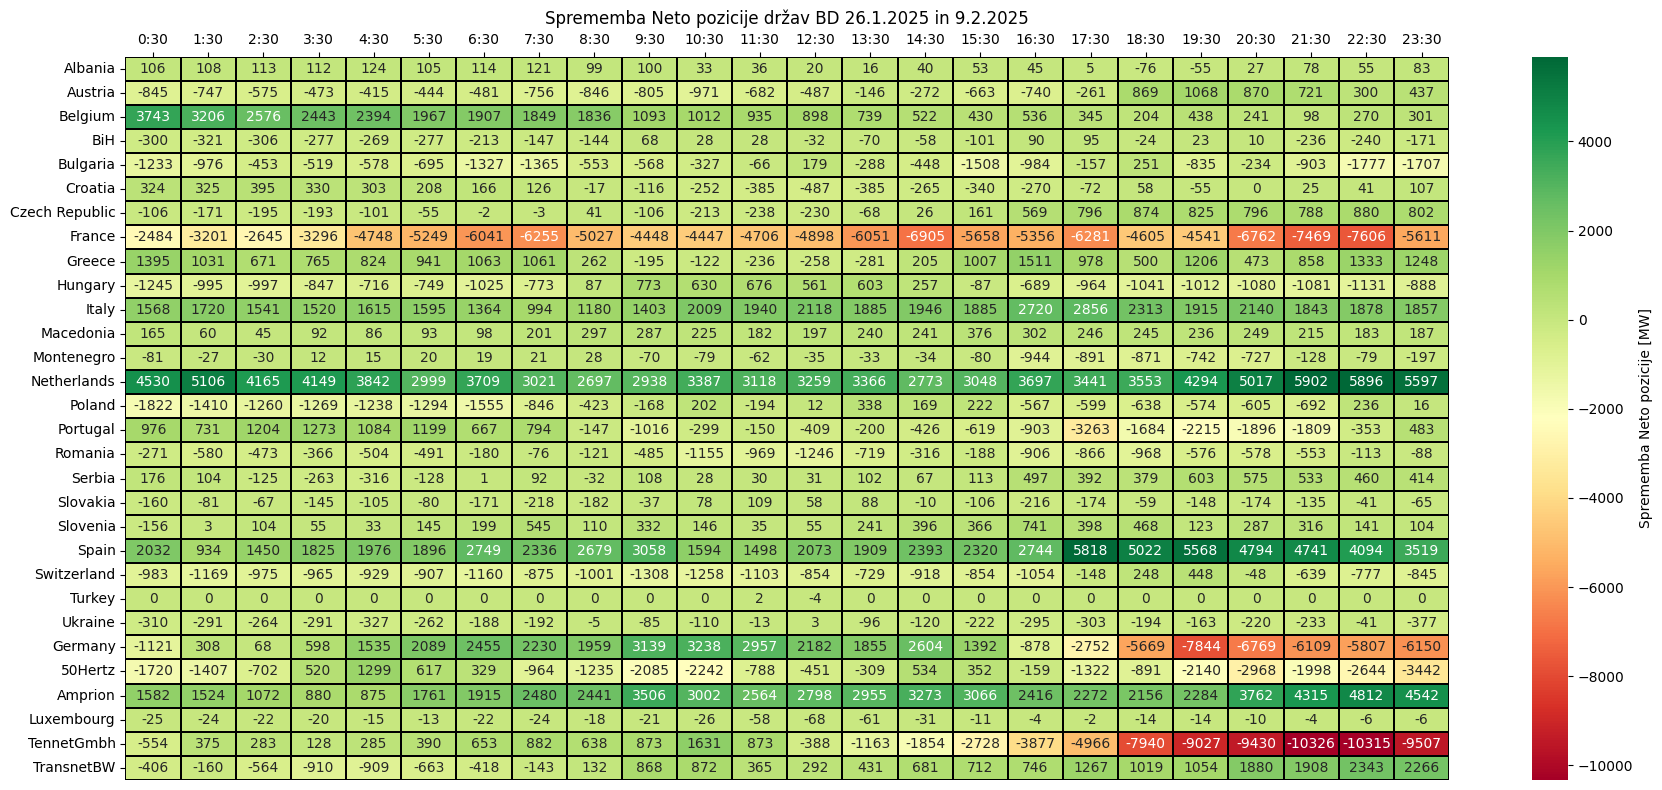

In [39]:
c = (a - b)*(-1)
# Create heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(c, cmap='RdYlGn', annot=True, fmt='.0f',linecolor='black', linewidths=0.1, cbar_kws={'label': 'Sprememba Neto pozicije [MW]'})
# Configure plot
plt.title(f'Sprememba Neto pozicije držav BD 26.1.2025 in 9.2.2025')
plt.ylabel('')
plt.xlabel('')
plt.yticks(rotation=0)
plt.gca().xaxis.set_ticks_position('top')
plt.tight_layout()
plt.show()

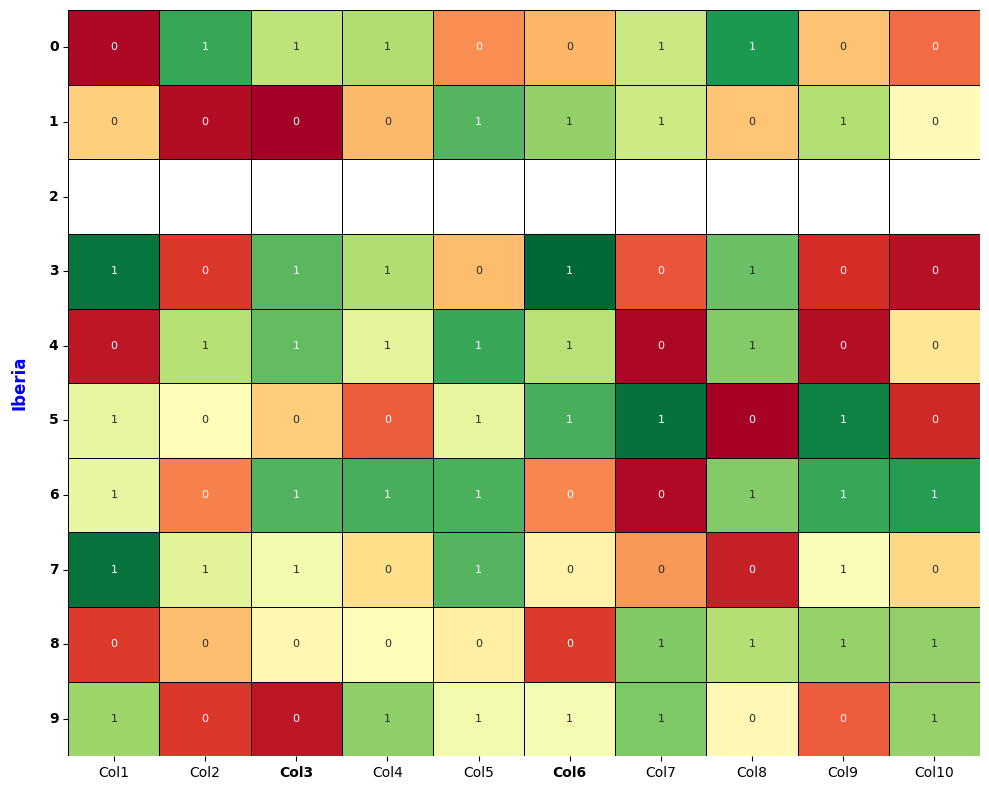

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Example DataFrame (replace with your own df_iberia)
data = np.random.rand(10, 10)  # Replace with df_iberia
df_iberia = pd.DataFrame(data, columns=[f'Col{i}' for i in range(1, 11)])

# Row index to highlight (for example, row index 2)
highlight_row_index = 2

# Create a mask for the specific row you want to highlight
mask = np.zeros_like(df_iberia, dtype=bool)
mask[highlight_row_index, :] = True  # Highlight the entire row

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_iberia, cmap='RdYlGn', annot=True, fmt='.0f', linecolor='black', linewidths=0.5, 
            cbar=False, vmin=df_iberia.min().min(), vmax=df_iberia.max().max(), annot_kws={"size": 8}, 
            ax=ax, mask=mask)

# Specific x-ticks you want to make bold (for example, columns 2 and 5)
specific_x_ticks = [2, 5]

# Get the current x-tick labels
x_tick_labels = ax.get_xticklabels()

# Modify specific x-tick labels to be bold
for i, label in enumerate(x_tick_labels):
    if i in specific_x_ticks:
        label.set_fontweight('bold')  # Make specific labels bold

# Adjust labels and appearance
ax.set_ylabel('Iberia', fontsize=12, color='blue', fontweight='bold', labelpad=15)
ax.set_xlabel('')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontweight='bold')  # Keep y-tick labels bold

# Adjust layout
plt.tight_layout()  # Adjust the layout to ensure no overlap
plt.show()
